In [46]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'
polbeamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles_polar/'

In [47]:
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_slice_xy(xes,yes,val,ax='x'):
    tol = 7#2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col


def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    return stat



In [48]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

find = 900

cmm = cm.magma
fsz=16

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY618_Corrected_amplitudes.pkl' 'FLY619_Corrected_amplitudes.pkl'
 'FLY620_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625

start of concat loop is: 2023-12-07 15:52:52.397557
end of concat loop is: 2023-12-07 15:52:56.171548          


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:368: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


start of concat loop is: 2023-12-07 15:52:59.810739
end of concat loop is: 2023-12-07 15:53:04.701018          


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:368: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


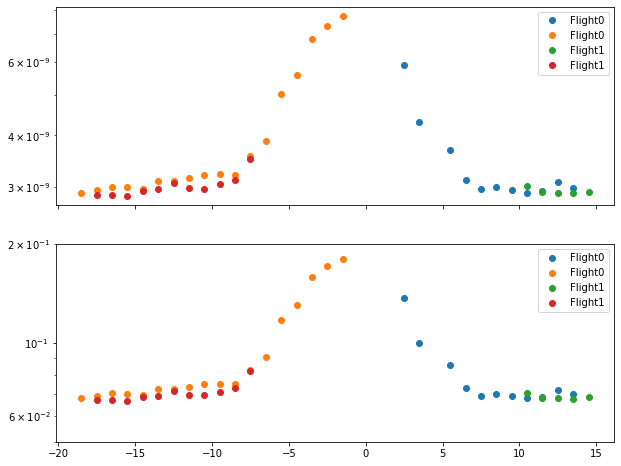

In [58]:
# N pols
concytest=['bgonly/FLY618_20211021T183430Z_ver_20231114T161857_concat_bgonly.pkl',
          'bgonly/FLY619_20211021T185805Z_ver_20231114T164442_concat_bgonly.pkl',
          'bgonly/FLY625_20211021T214028Z_ver_20231114T175419_concat_bgonly.pk',
          'bgonly/FLY646_20211022T183659Z_ver_20231114T181509_concat_bgonly.pkl',
          'bgonly/FLY647_20211022T185749Z_ver_20231114T183630_concat_bgonly.pkl',
          'bgonly/FLY533_20210826T182904Z_ver_20231114T150159_concat_bgonly.pkl',
          'bgonly/FLY536_20210826T195003Z_ver_20231114T155706_concat_bgonly.pkl']

# beammap a flight, without normalization, and see what hpappens

flights = Npolflights[0:2]
#concytest=[glob.glob(pckldir+'FLY'+fly+'*')[0] for fly in flights]

    
delt_the = np.radians(6)
delt_phi = np.radians(1)

chind = N_pols[0]

fig,axs = plt.subplots(2, 1, sharex=True,figsize=(10,8))  
for i in range(0,len(concytest[0:2])):
    beam=bp.Beammap(concatlist=[concytest[i]],
                 coordsys='polar',
                 d0args=[-delt_the/2.0,(60*delt_the)-(delt_the/2.0),delt_the],
                 d1args=[0,np.radians(36),delt_phi],
                 normalization='none',operation='coadd',Fargs=[find,find+1,1],vplot=False)
    
    col1,col2 = pu.get_polar_slice(beam.d0_centers_grid[:,:,chind],
                          beam.d1_centers_grid[:,:,chind],0.0)
    axs[0].semilogy(np.degrees(beam.d1_centers_grid[col1,:,chind]),beam.V_LC_operation[col1,:,0,chind],'o',
             label='Flight'+str(i))
    axs[0].semilogy(-1.0*np.degrees(beam.d1_centers_grid[col2,:,chind]),beam.V_LC_operation[col2,:,0,chind],'o',
             label='Flight'+str(i))
    axs[1].semilogy(np.degrees(beam.d1_centers_grid[col1,:,chind]),(1./GNORM_N[chind])*beam.V_LC_operation[col1,:,0,chind],'o',
             label='Flight'+str(i))
    axs[1].semilogy(-1.0*np.degrees(beam.d1_centers_grid[col2,:,chind]),(1./GNORM_N[chind])*beam.V_LC_operation[col2,:,0,chind],'o',
             label='Flight'+str(i))
axs[0].legend()
axs[1].legend()
#axs[0].set_ylim(1E-9,1E-7)
axs[1].set_ylim(5E-2,2E-1)
plt.show()




625 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/FLY625_20211021T214028Z_ver_20231114T175419_concat_bgonly.pkl'>
[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_ver_20231012T020905_concat.pkl'>
[ 4.17140671e-08 -1.45807029e+00  1.00157997e+01  1.16252174e+00
  9.34712163e+00  4.35349501e-10  0.00000000e+00]


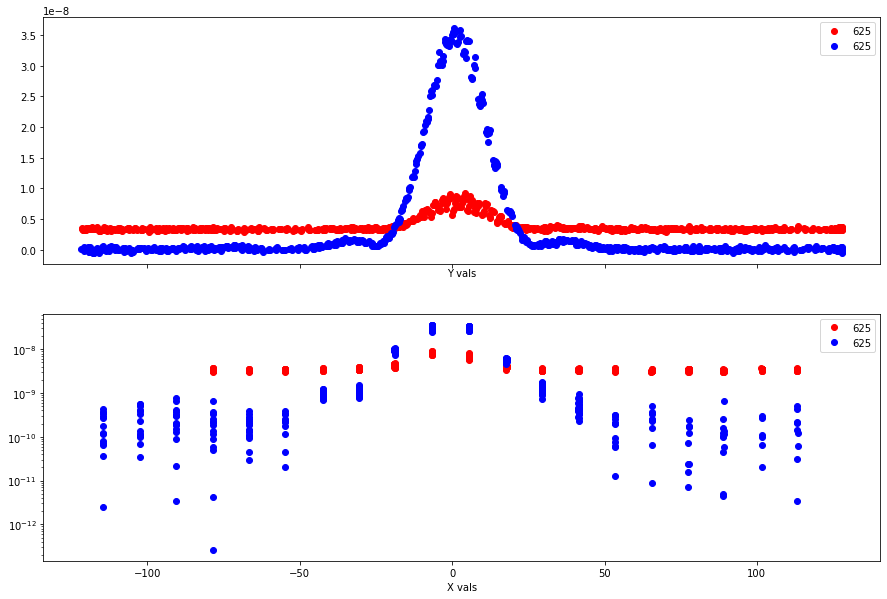

In [59]:
fly = '625'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
chind = pols[0]


#with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
#    print(pfile)
#    concattest618=pickle.load(pfile)
#GNORM = concattest618.G_popt[chind,find,0]
GNORM = 1.0

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618_bg=pickle.load(pfile)
t_cut_618=concattest618.inds_on
t_cut_618_off = concattest618.inds_off


## Background data: 

chind=pols[0]
print(concattest618.G_popt[chind,find,:])

x = concattest618_bg.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618_bg.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618_bg.V_bg[t_cut_618,find,chind]/GNORM

fig,axs = plt.subplots(2, 1, sharex=True,figsize=(15,10),squeeze=True)

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
axs[0].plot(y[ixd],z[ixd],marker='o',linestyle='None',label=fly,color='red')
ixd = get_slice_xy(x,y,0.0,ax='y') # grabbed x slice
axs[1].semilogy(x[ixd],z[ixd],marker='o',linestyle='None',label=fly,color='red')
    

# regular on data
with open(glob.glob('/hirax/GBO_Analysis_Outputs/flight_pickles/'+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618=pickle.load(pfile)
t_cut_618=concattest618.inds_on
t_cut_618_off = concattest618.inds_off

#/hirax/GBO_Analysis_Outputs/flight_pickles/


## Let's start by checking regular co-pol normalization - N pol: 

chind=pols[0]
print(concattest618.G_popt[chind,find,:])

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind]/GNORM

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
axs[0].plot(y[ixd],z[ixd],marker='o',linestyle='None',label=fly,color='blue')
ixd = get_slice_xy(x,y,0.0,ax='y') # grabbed x slice
axs[1].semilogy(x[ixd],z[ixd],marker='o',linestyle='None',label=fly,color='blue')




axs[0].legend()
axs[1].legend()
axs[0].set_xlabel('Y vals')
axs[1].set_xlabel('X vals')
#axs[0].set_xlim(-40,40)
plt.show()


In [61]:
### All the way back to the beginning

Epols = [0,2,4,6,8,10,12,14]
Npols = [1,3,5,7,9,11,13,15]
config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

# dishes are 2n, 2n+1 pairs

8 FLIGHT:  625
20211021T214040Z /hirax/GBO_Oct_2021/TONE_ACQ/20211021T214028Z_yale_drone/corr/20211021T214040Z/ /hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/20211021T214028Z_yale_drone_yale_digitalgain/
Initializing drone data via datcon_csv routine: FLY625.csv
  --> Skipping rows 1 to 3399 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 0/9100 non-nan values
    --> RTK Data not usable for this data file...
  --> Loading position data from GPS(0) instead:
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
DONE reading in drone data
2021-10-21 21:44:43.399000+00:00 2021-10-21 21:59:55.402000+00:00
start time:  2023-12-07 15:55:38.848363
Initializing Correlator Class using:
  --> /hirax/GBO_Oct_2021/TONE_ACQ/20211021T214028Z_yale_drone/corr/20211021T214040Z/
  --> Arrays initialized with shape (125, 256

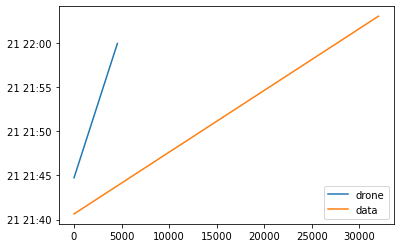

In [62]:
# Read the yaml for the flight you're interested in:
fly = '625'

f = -1
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print(f, 'FLIGHT: ', documents["flight_info"]["flights"][f])

fly = flights[f]
tub = documents["flight_info"]["tubs"][f]
tlb = documents["flight_info"]["tlbs"][f]
cdat = documents["flight_info"]["cdats"][f]
tclb = documents["flight_info"]["tclbs"][f]
tcub = documents["flight_info"]["tcubs"][f]
fmax = documents["flight_info"]["fmaxes"][f]

if int(fly) < 537:
    mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
    gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
else:
    mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
    gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

sdir = os.listdir(mdir)[0]
datadir=mdir+sdir+'/'
print(sdir, datadir,gaindir)
    
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=tlb,tub=tub)

print('DONE reading in drone data')
print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])

## Combine drone and correlator data
print('start time: ', datetime.datetime.now())
if str(fmax) != 'None':# 
    corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                            Gain_Directory=gaindir,site_class=gbosite,
                            crossmap=[],Data_File_Index=np.arange(0,int(fmax)))
else:
    corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                            Gain_Directory=gaindir,site_class=gbosite,
                            crossmap=[])
#

    
print('end time: ', datetime.datetime.now())

# putting checks in one cell now that I know I've mostly figured out the flight/corr file correspondence
# This checks I copied and pasted ok :)

## plot their datetime arrays to check overlap:

plot(dronetest0825.t_arr_datetime,label='drone')
plot(corrtest0825.t_arr_datetime,label='data')
legend()


In [63]:
config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             load_yaml=False,traceback=False,save_traceback=False)


In [64]:
print('start time: ', datetime.datetime.now())
concattest0825.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[tclb+2500,tcub-2500])
#concattest0825.Extract_Source_Pulses(Period=400000,Dutycycle=200000,t_bounds=[tclb,tcub],f_ind=900)

print('end time: ', datetime.datetime.now())

start time:  2023-12-07 16:06:06.028825


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:230: RuntimeWarning: invalid value encountered in true_divide
  normminsubdata=minsubdata/np.percentile(minsubdata,minmaxpercents[1])
/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:247: RuntimeWarning: All-NaN slice encountered
  maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]


end time:  2023-12-07 16:08:45.577831


/hirax/GBO_Analysis_Outputs/main_beam_fits/FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz
12601 6792 12607


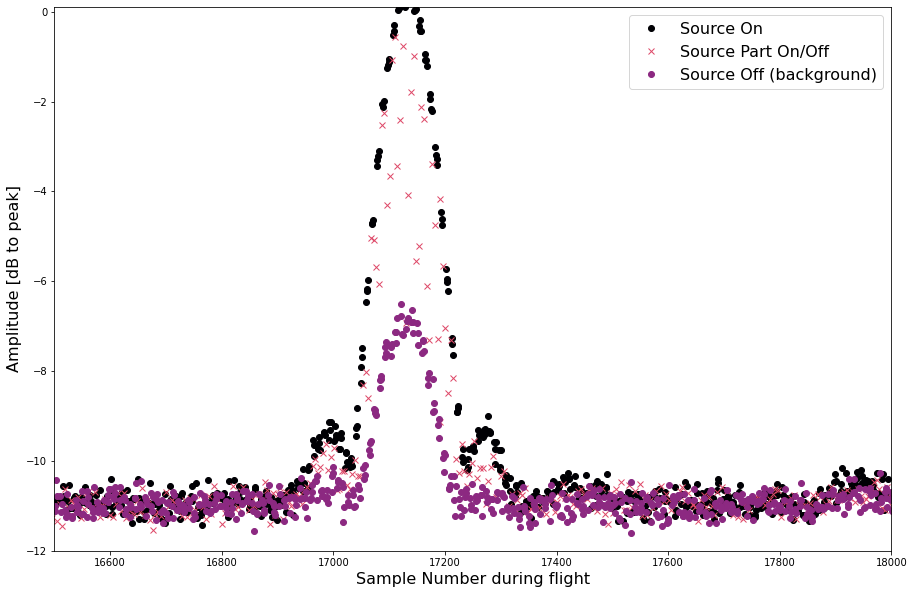

In [87]:
find = 900
chind = 1
fsz = 16 # fontsize for labels and legends
ccm = cm.magma # use magma for color maps

colorz = pu.cm_to_discrete(ccm, 5)

ffile = glob.glob(fitdir+'*625*')[0]
print(ffile)
fits = np.load(ffile)
#for p in range(0,len(pols)):
GNORM = fits['G_popt'][chind,find,0]


# aside to look at the span, on, and off indices in more detail

t_cut = concattest0825.inds_on
t_span = concattest0825.inds_span
t_off = concattest0825.inds_off
N = len(t_cut)
N2 = int(N/2)
print(len(t_cut),len(t_span),len(t_off))

Ns = np.arange(0,len(concattest0825.t_arr_datetime))
plt.figure(1,figsize=(15,10))

plt.plot(Ns[t_cut],10*np.log10((1./GNORM)*concattest0825.V[t_cut,find,chind]),
         color=colorz[0],linestyle='None',marker='o',label='Source On')
plt.plot(Ns[t_span],10*np.log10((1./GNORM)*concattest0825.V[t_span,find,chind]),
         color=colorz[3],linestyle='None',marker='x',label='Source Part On/Off')
plt.plot(Ns[t_off],10*np.log10((1./GNORM)*concattest0825.V[t_off,find,chind]),
         color=colorz[2],linestyle='None',marker='o',label='Source Off (background)')
plt.xlim(16500,18000)
plt.legend(fontsize=fsz)
plt.xlabel('Sample Number during flight',fontsize=fsz)
plt.ylabel('Amplitude [dB to peak]',fontsize=fsz)
plt.ylim(-12,0.1)
plt.show()

In [71]:
print(GNORM.shape)

(16, 1024)
